## Introduction

Bike sharing systems are a means of renting bicycles where the process of obtaining membership, rental, and bike return is automated via a network of kiosk locations throughout a city. Using these systems, people are able rent a bike from a one location and return it to a different place on an as-needed basis. Currently, there are over 500 bike-sharing programs around the world.

The data generated by these systems makes them attractive for researchers because the duration of travel, departure location, arrival location, and time elapsed is explicitly recorded. Bike sharing systems therefore function as a sensor network, which can be used for studying mobility in a city. In this competition, participants are asked to combine historical usage patterns with weather data in order to forecast bike rental demand in the Capital Bikeshare program in Washington, D.C.


Evaluation:
Submissions are evaluated one the Root Mean Squared Logarithmic Error (RMSLE

__This solution is available as a docker container: docker pull shankze/bikeshare-image__

### Data

datetime - hourly date + timestamp   
season -  1 = spring, 2 = summer, 3 = fall, 4 = winter   
holiday - whether the day is considered a holiday  
workingday - whether the day is neither a weekend nor holiday  
weather - 1: Clear, Few clouds, Partly cloudy, Partly cloudy   
2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist   
3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds   
4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog   
temp - temperature in Celsius  
atemp - "feels like" temperature in Celsius  
humidity - relative humidity  
windspeed - wind speed  
casual - number of non-registered user rentals initiated  
registered - number of registered user rentals initiated  
count - number of total rentals  

Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.io.json import json_normalize
import scipy.stats as stats
import pylab
from numpy.random import seed
from numpy.random import randn
from scipy.stats import shapiro
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
%matplotlib inline

Importing datasets

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [3]:
print(f'Shape of train dataset: {str(train.shape)}')
print(f'Shape of test dataset: {str(test.shape)}')

Shape of train dataset: (10886, 12)
Shape of test dataset: (6493, 9)


In [4]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [5]:
train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


In [6]:
def generateColumnInfo(df):
    cls = []
    nullCount = []
    nonNullCount = []
    nullsPct = []
    uniqCount = []
    dataType = []
    for i,col in enumerate(df.columns):
        cls.append(col)
        nullCount.append(df[col].isnull().sum())
        nonNullCount.append(len(df)-df[col].isnull().sum())
        nullsPct.append((df[col].isnull().sum())*(100)/len(df))
        uniqCount.append(df[col].nunique())
        dataType.append(df[col].dtype)
        
    column_info = pd.DataFrame(
        {'ColumnName': cls,
         'NullCount': nullCount,
         'NonNullCount': nonNullCount,
         'NullPercent': nullsPct,
         'UniqueValueCount': uniqCount,
         'DataType':dataType
        })
    return(column_info)

In [7]:
generateColumnInfo(train)

,ColumnName,NullCount,NonNullCount,NullPercent,UniqueValueCount,DataType
0,datetime,0,10886,0.0,10886,object
1,season,0,10886,0.0,4,int64
2,holiday,0,10886,0.0,2,int64
3,workingday,0,10886,0.0,2,int64
4,weather,0,10886,0.0,4,int64
5,temp,0,10886,0.0,49,float64
6,atemp,0,10886,0.0,60,float64
7,humidity,0,10886,0.0,89,int64
8,windspeed,0,10886,0.0,28,float64
9,casual,0,10886,0.0,309,int64


In [8]:
generateColumnInfo(test)

,ColumnName,NullCount,NonNullCount,NullPercent,UniqueValueCount,DataType
0,datetime,0,6493,0.0,6493,object
1,season,0,6493,0.0,4,int64
2,holiday,0,6493,0.0,2,int64
3,workingday,0,6493,0.0,2,int64
4,weather,0,6493,0.0,4,int64
5,temp,0,6493,0.0,49,float64
6,atemp,0,6493,0.0,65,float64
7,humidity,0,6493,0.0,79,int64
8,windspeed,0,6493,0.0,27,float64


Train contains 3 additional columns : casual, registered and count. There are no null values. We will start by converting the text column "datetime" to datetime type. We will extract the date related columns and drop the original column from the train set. We need to retain the datetime column on the test set as it is required to submit the results.

In [9]:
train['date'] = pd.to_datetime(train['datetime'],format='%Y-%m-%d')
train.drop(['datetime'],axis=1,inplace=True)
train['date_year'],train['date_month'],train['date_day'],train['date_weekday'],train['date_hour']  = train['date'].dt.year,train['date'].dt.month,train['date'].dt.day,train['date'].dt.weekday,train['date'].dt.hour
train['weekday_name'] = train['date'].dt.weekday_name

test['date'] = pd.to_datetime(test['datetime'],format='%Y-%m-%d')
test['date_year'],test['date_month'],test['date_day'],test['date_weekday'],test['date_hour']  = test['date'].dt.year,test['date'].dt.month,test['date'].dt.day,test['date'].dt.weekday,test['date'].dt.hour

In [10]:
train.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,date_year,date_month,date_day,date_weekday,date_hour,weekday_name
0,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011-01-01 00:00:00,2011,1,1,5,0,Saturday
1,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011-01-01 01:00:00,2011,1,1,5,1,Saturday
2,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011-01-01 02:00:00,2011,1,1,5,2,Saturday
3,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011-01-01 03:00:00,2011,1,1,5,3,Saturday
4,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011-01-01 04:00:00,2011,1,1,5,4,Saturday


### Distribution of dependant variable

We see many outliers (3×IQR) in the boxplot.

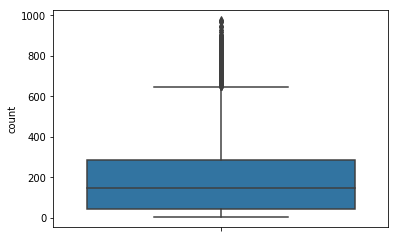

In [11]:
sns.boxplot(train['count'],orient='v')

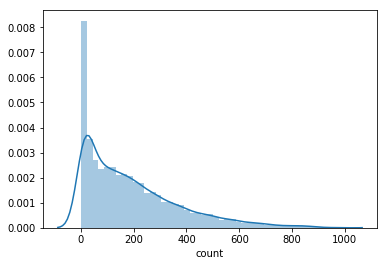

In [12]:
sns.distplot(train['count'])

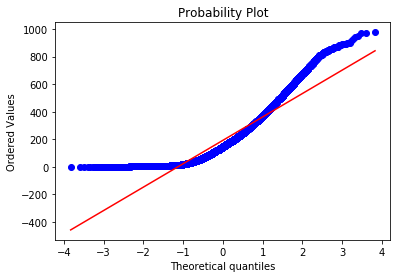

In [13]:
measurements = np.random.normal(loc = 20, scale = 5, size=100)   
stats.probplot(train['count'], dist="norm", plot=pylab)
pylab.show()

The 'count' variable has a right skew. Quantile-Quantile plot shows that it is not showing normal distribution. Shapiro-Wilk's test confirms this behavior.

In [14]:
#Shapiro–Wilk test
stat, p = shapiro(train['count'])
print('p=%.3f' % (p)) #Normal if p>0.1

p=0.000


D:\Anaconda\lib\site-packages\scipy\stats\morestats.py:1310: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Log transformation of the dependant variable improves the distribution. I will use the log transformation for statistical modeling.

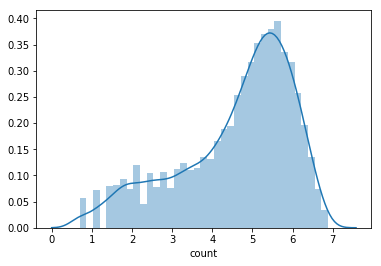

In [15]:
sns.distplot(np.log1p(train['count']))

## Exploratory data analysis (EDA)

In [16]:
#creating additional dataframe for EDA
byUserType = train.drop(['count'],axis=1)
byUserType = pd.melt(byUserType,id_vars = ['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed', 'date',
       'date_year', 'date_month', 'date_day', 'date_weekday', 'date_hour',
       'weekday_name'],value_vars = ['casual', 'registered'],var_name='user_type',value_name='user_count')

I will analyze each column in this section. I will start with the date/time based columns.

### Date Columns

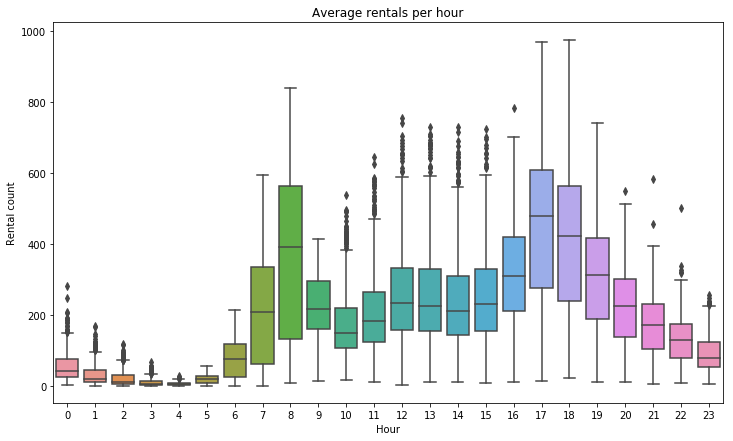

In [17]:
plt.figure(figsize=(12,7))
sns.boxplot(data=train, x='date_hour',y='count')
plt.title('Average rentals per hour')
plt.xlabel('Hour')
plt.ylabel('Rental count')
plt.show()

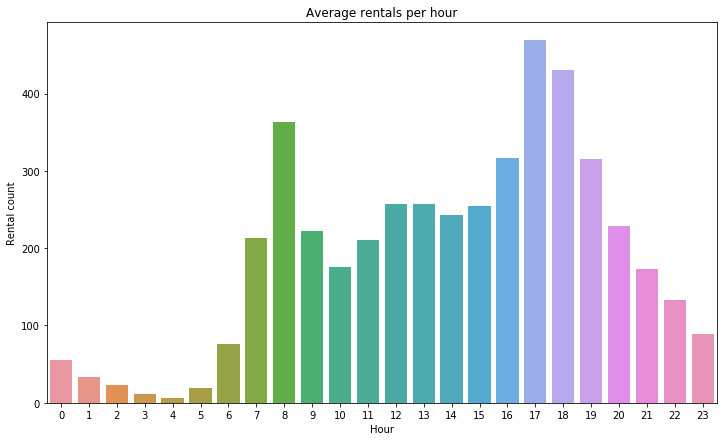

In [18]:
plt.figure(figsize=(12,7))
sns.barplot(data=train,x='date_hour',y='count',ci=None)
plt.title('Average rentals per hour')
plt.xlabel('Hour')
plt.ylabel('Rental count')
plt.show()

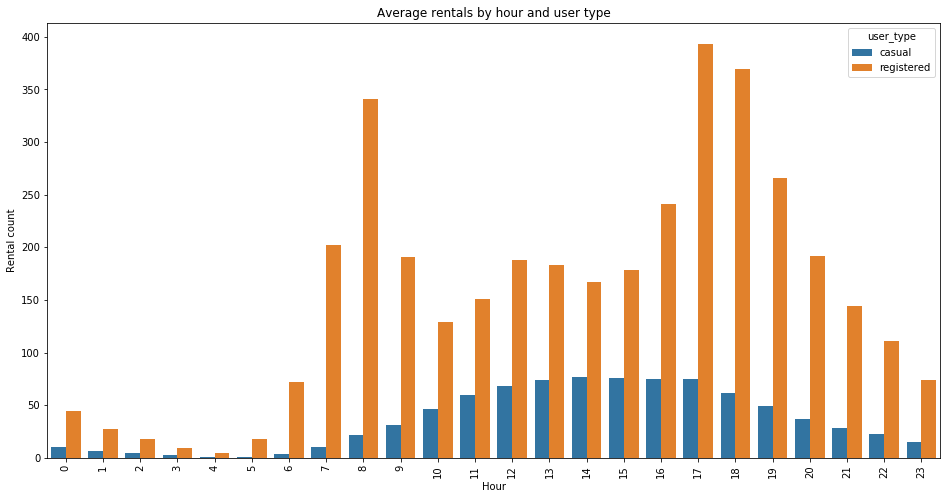

In [19]:
plt.figure(figsize=(16,8))
plt.xticks(rotation=90)
ax = sns.barplot(data=byUserType,x='date_hour',y='user_count',hue='user_type',ci=None)
plt.title('Average rentals by hour and user type')
plt.xlabel('Hour')
plt.ylabel('Rental count')
plt.show()

Demand is relatively high between 7am-9am and 4pm-7pm. This high demand is fueled by registered users. The demand from casual users is high between 11am-5pm. This could be attributed to the visitors and it coincides with the timings of major tourist attractions in the DC area.

<Figure size 864x504 with 0 Axes>

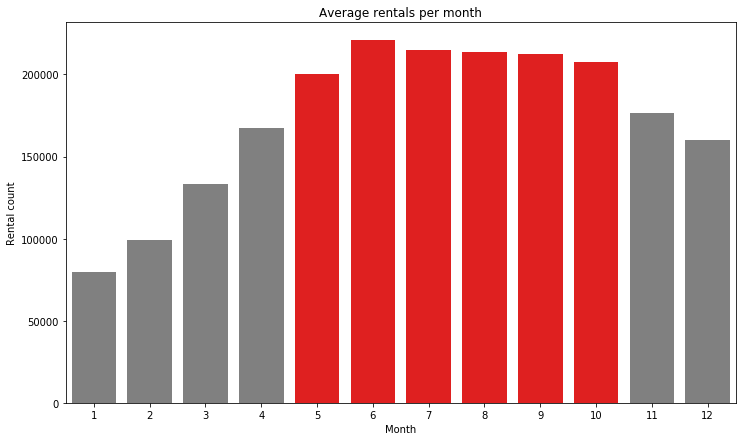

In [20]:
plt.figure(figsize=(12,7))
countByMonth = train.groupby(['date_month'],as_index=False).sum()[['date_month','count']]
ids = countByMonth['date_month']
values = countByMonth['count']
plt.figure(figsize=(12,7))
clrs = ['grey' if (x < 180000) else 'red' for x in values ]
sns.barplot(x=ids,y=values,ci=None,palette=clrs)
plt.title('Average rentals per month')
plt.xlabel('Month')
plt.ylabel('Rental count')
plt.show()

Demand is high during the summer months (May to October). Both registered and casual riders show the same behavior.

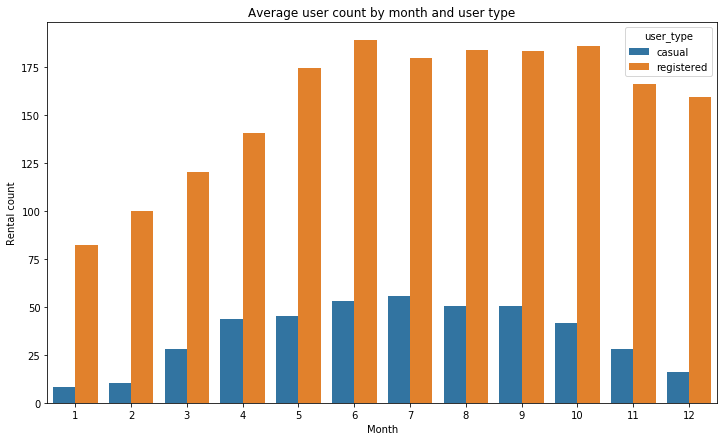

In [21]:
plt.figure(figsize=(12,7))
sns.barplot(data=byUserType,x='date_month',y='user_count',hue='user_type',ci=None)
plt.title('Average user count by month and user type')
plt.xlabel('Month')
plt.ylabel('Rental count')
plt.show()

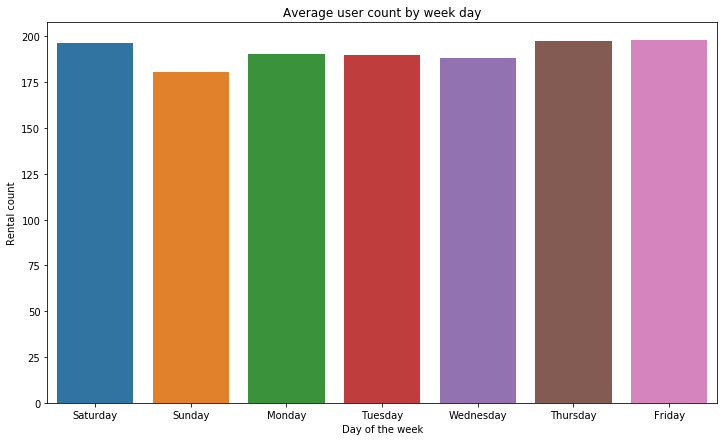

In [22]:
plt.figure(figsize=(12,7))
sns.barplot(data=train,x='weekday_name',y='count',ci=None)
plt.title('Average user count by week day')
plt.xlabel('Day of the week')
plt.ylabel('Rental count')
plt.show()

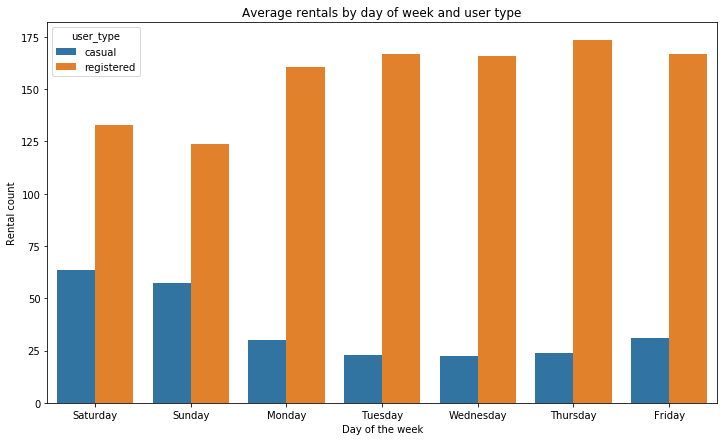

In [23]:
plt.figure(figsize=(12,7))
sns.barplot(data=byUserType,x='weekday_name',y='user_count',hue='user_type',ci=None)
plt.title('Average rentals by day of week and user type')
plt.xlabel('Day of the week')
plt.ylabel('Rental count')
plt.show()

* Demand from registered users is higher on weekdays. 
* Demand from casual users is higher on weekends.

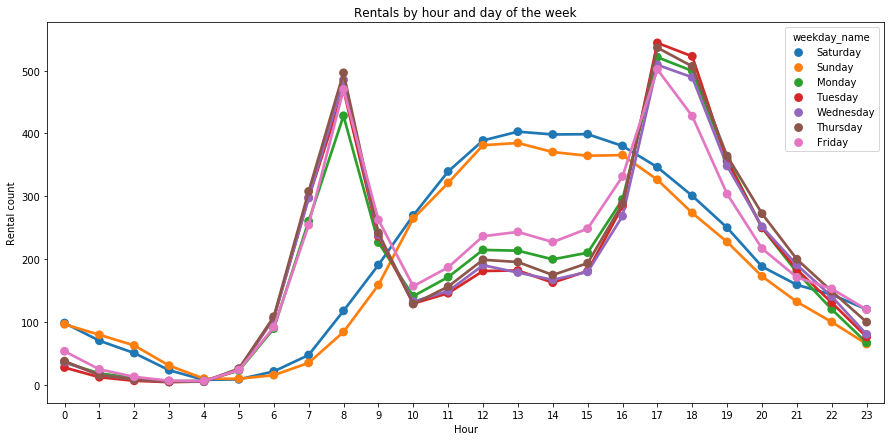

In [24]:
plt.figure(figsize=(15,7))
sns.pointplot(data=train,x='date_hour',y='count',hue='weekday_name',ci=None)
plt.title('Rentals by hour and day of the week')
plt.xlabel('Hour')
plt.ylabel('Rental count')
plt.show()

* There is a significant difference in the demand between weekdays and weekends.
* On weekdays, the peak demand is during commuting hours (7am-9am) and (4pm-7pm).
* On weekends, the peak demand is betwwen  noon and 4pm.

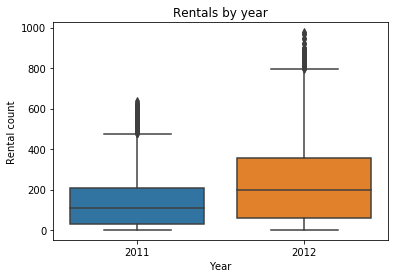

In [25]:
sns.boxplot(data=train,x='date_year',y='count')
plt.title('Rentals by year')
plt.xlabel('Year')
plt.ylabel('Rental count')
plt.show()

Text(0,0.5,'Rental count')

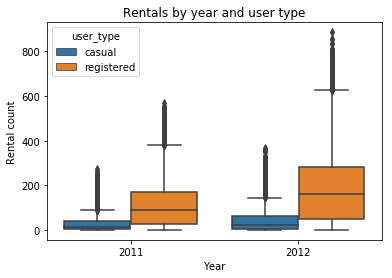

In [26]:
sns.boxplot(data=byUserType,x='date_year',y='user_count',hue="user_type")
plt.title('Rentals by year and user type')
plt.xlabel('Year')
plt.ylabel('Rental count')

### Season

D:\Anaconda\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


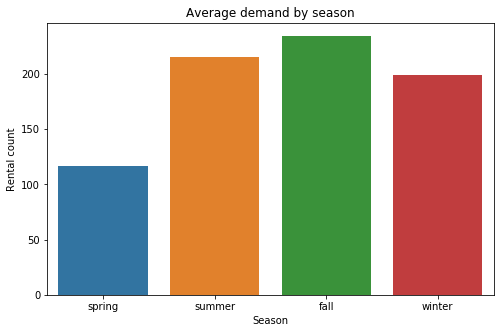

In [27]:
plt.figure(figsize=(8,5))
sns.barplot(data=train,x='season',y='count',ci=None)
ax = plt.axes()
plt.xticks(rotation=0)
ax.set_xticklabels(['spring','summer','fall','winter'])
plt.title('Average demand by season')
plt.xlabel('Season')
plt.ylabel('Rental count')
plt.show()

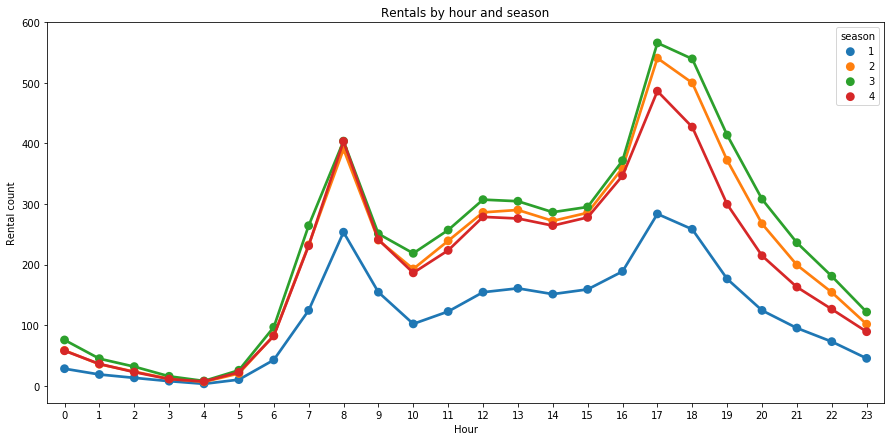

In [28]:
plt.figure(figsize=(15,7))
g = sns.pointplot(data=train,x='date_hour',y='count',hue='season',ci=None)
plt.title('Rentals by hour and season')
plt.xlabel('Hour')
plt.ylabel('Rental count')
plt.show()

### Holiday and Working Days

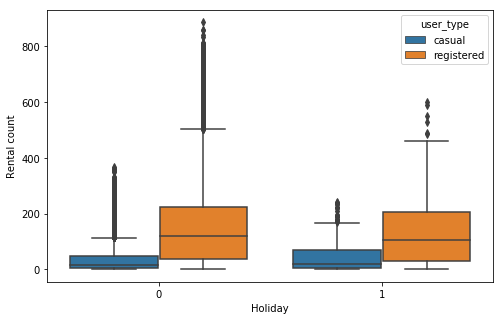

In [29]:
plt.figure(figsize=(8,5))
sns.boxplot(data=byUserType,x='holiday',y='user_count',hue='user_type')
plt.xlabel('Holiday')
plt.ylabel('Rental count')
plt.show()

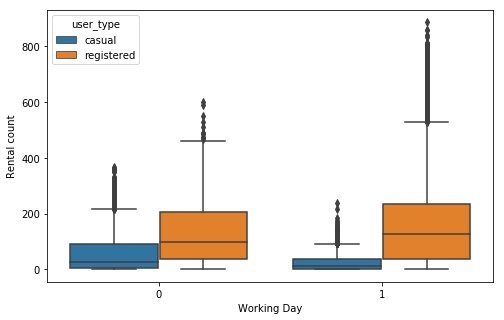

In [30]:
plt.figure(figsize=(8,5))
sns.boxplot(data=byUserType,x='workingday',y='user_count',hue='user_type')
plt.xlabel('Working Day')
plt.ylabel('Rental count')
plt.show()

* Demand from registered users is higher during working days
* Demand from casual users is higher during hilidays

### Weather

D:\Anaconda\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


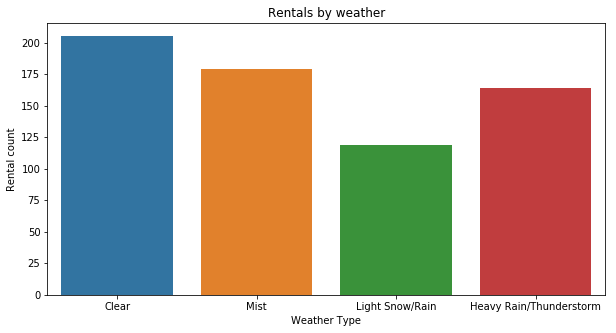

In [31]:
plt.figure(figsize=(10,5))
sns.barplot(data=train,x='weather',y='count',ci=None)
plt.title('')
ax = plt.axes()
plt.xticks(rotation=0)
ax.set_xticklabels(['Clear','Mist','Light Snow/Rain','Heavy Rain/Thunderstorm'])
plt.title('Rentals by weather')
plt.xlabel('Weather Type')
plt.ylabel('Rental count')
plt.show()

* People prefer to rent bikes during good weather. 
* Interestingly, there is higher demand during Heavy Rains and Thunderstorms than during light rain or snow.

### Temperature

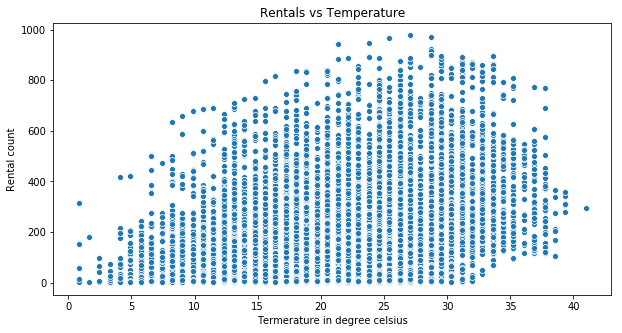

In [32]:
plt.figure(figsize=(10,5))
sns.scatterplot(data=train,x='temp',y='count',ci=None)
plt.title('Rentals vs Temperature')
plt.xlabel('Termerature in degree celsius')
plt.ylabel('Rental count')
plt.show()

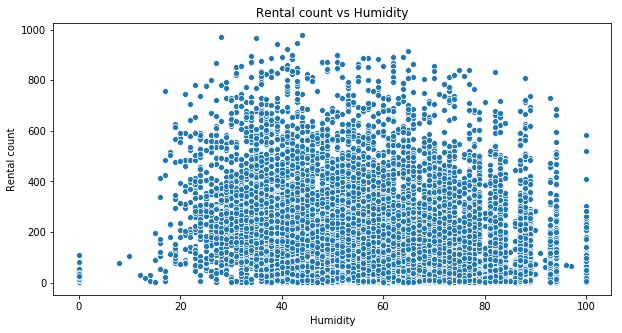

In [33]:
plt.figure(figsize=(10,5))
sns.scatterplot(data=train,x='humidity',y='count',ci=None)
plt.title('Rental count vs Humidity')
plt.xlabel('Humidity')
plt.ylabel('Rental count')
plt.show()

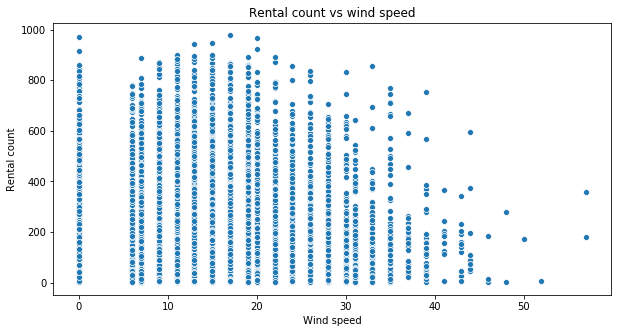

In [34]:
plt.figure(figsize=(10,5))
sns.scatterplot(data=train,x='windspeed',y='count',ci=None)
plt.title('Rental count vs wind speed')
plt.xlabel('Wind speed')
plt.ylabel('Rental count')
plt.show()

In [35]:
train.drop(['weekday_name'],inplace=True,axis=1)

## Feature Engineering

In [36]:
generateColumnInfo(train)

,ColumnName,NullCount,NonNullCount,NullPercent,UniqueValueCount,DataType
0,season,0,10886,0.0,4,int64
1,holiday,0,10886,0.0,2,int64
2,workingday,0,10886,0.0,2,int64
3,weather,0,10886,0.0,4,int64
4,temp,0,10886,0.0,49,float64
5,atemp,0,10886,0.0,60,float64
6,humidity,0,10886,0.0,89,int64
7,windspeed,0,10886,0.0,28,float64
8,casual,0,10886,0.0,309,int64
9,registered,0,10886,0.0,731,int64


In [37]:
generateColumnInfo(test)

,ColumnName,NullCount,NonNullCount,NullPercent,UniqueValueCount,DataType
0,datetime,0,6493,0.0,6493,object
1,season,0,6493,0.0,4,int64
2,holiday,0,6493,0.0,2,int64
3,workingday,0,6493,0.0,2,int64
4,weather,0,6493,0.0,4,int64
5,temp,0,6493,0.0,49,float64
6,atemp,0,6493,0.0,65,float64
7,humidity,0,6493,0.0,79,int64
8,windspeed,0,6493,0.0,27,float64
9,date,0,6493,0.0,6493,datetime64[ns]


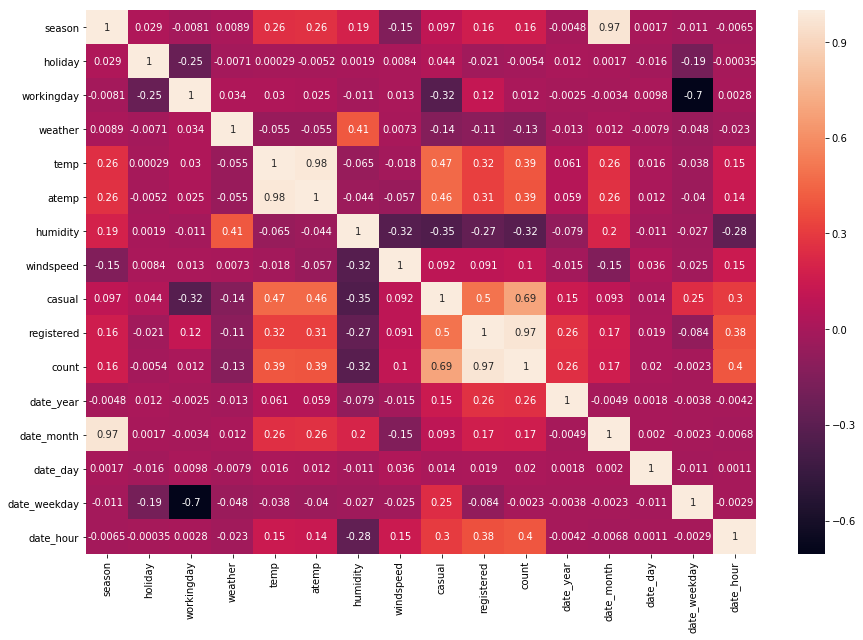

In [38]:
plt.figure(figsize=(15,10))
sns.heatmap(train.corr(),annot=True)
plt.show()

* Date_hour shows the highes correlation with count.
* There is a very high co-relation between season and date_month and temp and atemp. 
* I will drop season and atemp columns to avoid multicollinearity.

In [39]:
train.drop(['season','atemp'],inplace=True,axis=1)
test.drop(['season','atemp'],inplace=True,axis=1)

One hot encoding "weather"

In [40]:
train = pd.get_dummies(train, columns=['weather'], prefix=['weather_'])
test = pd.get_dummies(test, columns=['weather'], prefix=['weather_'])

The date column is no longer required.

In [41]:
train.drop('date',inplace=True,axis=1)
test.drop('date',inplace=True,axis=1)

In [42]:
train['date_year'] = train['date_year'].astype("category")
train['date_month'] = train['date_month'].astype("category")
train['date_day'] = train['date_day'].astype("category")
train['date_weekday'] = train['date_weekday'].astype("category")
train['date_hour'] = train['date_hour'].astype("category")

## Statistical Modeling

In [43]:
X = train.drop(['count','casual','registered'],axis=1)
y = train['count']

In [44]:
X_train,X_valid, y_train,y_valid = train_test_split(X,y, test_size=0.3,random_state=100)

In [45]:
res_alg = ['Random Forest','SVR','KNN','GBR','LR']
res_rmsle = []

In [46]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV

In [47]:
#Random forest
rfModel = RandomForestRegressor()
rfModel.fit(X_train,np.log1p(y_train))
rfPred = rfModel.predict(X_valid)
np.sqrt(mean_squared_log_error(np.exp(rfPred),y_valid))
res_rmsle.append(np.sqrt(mean_squared_log_error(np.exp(rfPred),y_valid)))

In [48]:
#Support vector regression
svrModel = SVR()
svrModel.fit(X_train,np.log1p(y_train))
svrPred = svrModel.predict(X_valid)
res_rmsle.append(np.sqrt(mean_squared_log_error(np.exp(svrPred),y_valid)))

In [49]:
#K-nearest neighbors
knnModel = KNeighborsRegressor()
knnModel.fit(X_train,np.log1p(y_train))
knnPred = knnModel.predict(X_valid)
res_rmsle.append(mean_squared_log_error(np.exp(knnPred),y_valid))

In [50]:
#Gradient boosting regressor
gbModel = GradientBoostingRegressor()
gbModel.fit(X_train,np.log1p(y_train))
gbPred = gbModel.predict(X_valid)
gbPred = pd.DataFrame(gbPred)
gbPred = gbPred[0].apply(lambda x:0.0 if x<0 else x)
res_rmsle.append(np.sqrt(mean_squared_log_error(np.exp(gbPred),y_valid)))

In [51]:
#Linear regression
lrModel = LinearRegression()
lrModel.fit(X_train,np.log1p(y_train))
lrPred = lrModel.predict(X_valid)
lrPred = pd.DataFrame(lrPred)
lrPred = lrPred[0].apply(lambda x:0.0 if x<0 else x)
res_rmsle.append(np.sqrt(mean_squared_log_error(np.exp(lrPred),y_valid)))

In [52]:
results = pd.DataFrame({'Algorithm':res_alg,'RMSLE':res_rmsle})
results.sort_values('RMSLE')

,Algorithm,RMSLE
0,Random Forest,0.338849
3,GBR,0.405260
2,KNN,0.691466
1,SVR,0.942840
4,LR,1.011953


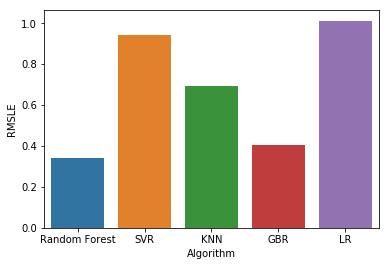

In [53]:
sns.barplot(data=results,x='Algorithm',y='RMSLE')

Random forest gives the lowest RMSLE value. In the next section, I will tune the hyperparameters of the random forest model.

## Tuning

### Random Search

I will define a grid of hyperparameters and use Scikit-Learn’s RandomizedSearchCV method to randomly sample from the grid, performing K-Fold CV with each combination of values. RandomizedSearchCV will not try every combination, but selects at random to sample a wide range of values.K-Fold CV reduces overfitting. I will try adjusting the following set of hyperparameters:

* n_estimators = number of trees in the foreset
* max_features = max number of features considered for splitting a node
* max_depth = max number of levels in each decision tree
* min_samples_split = min number of data points placed in a node before the node is split
* min_samples_leaf = min number of data points allowed in a leaf node
* bootstrap = method for sampling data points (with or without replacement)

In [54]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

In [55]:
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [56]:
from sklearn.model_selection import RandomizedSearchCV

In [57]:
rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=1, random_state=42, n_jobs = -1,scoring='neg_mean_squared_log_error')

In [58]:
rf_random.fit(X_train,np.log1p(y_train))

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 11.4min finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_log_error',
          verbose=1)

In [59]:
rf_random.best_params_

{'bootstrap': True,
 'max_depth': 100,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 1400}

### Grid Search CV

Now that we know the range for each hyperparameter, I will fine tune the hyperparameters with GridSearchCV. GridSearchCV will perform KFold Cross validation on each combination. 

In [60]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [100,120,150],
    'max_features': ['auto'],
    'min_samples_leaf': [1,2],
    'min_samples_split': [2,3,4],
    'n_estimators': [500,800,1000 ]
}

In [61]:
from sklearn.model_selection import GridSearchCV

In [62]:
rf = RandomForestRegressor()
rf_grid = GridSearchCV(estimator =rf,param_grid=param_grid,scoring='neg_mean_squared_log_error',verbose=1,cv=3)

In [63]:
rf_grid.fit(X_train,np.log1p(y_train))
pred=rf_grid.predict(X_valid)

Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=1)]: Done 162 out of 162 | elapsed: 29.6min finished


In [64]:
print((np.sqrt(mean_squared_log_error(np.exp(pred),y_valid))))

0.317396652773138


Tuning has led to a decrease in the RMSLE value. Let us look at the final hyperparameters:

In [65]:
rf_grid.best_params_

{'bootstrap': True,
 'max_depth': 150,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_estimators': 800}

In [67]:
f_imp = pd.DataFrame({'Feature':X_train.columns,'Importance':rf_grid.best_estimator_.feature_importances_})

Text(0.5,1,'Feature Importance')

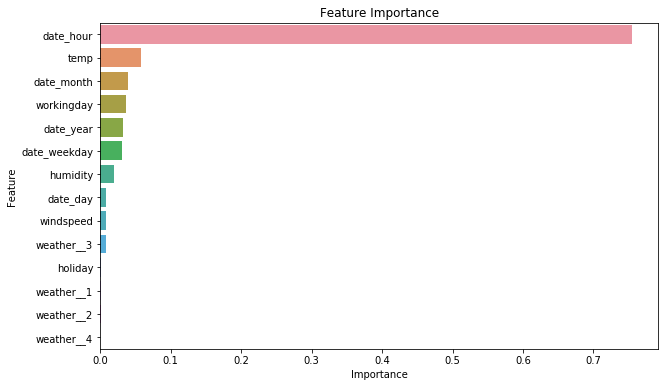

In [68]:
plt.figure(figsize=(10,6))
sns.barplot(data=f_imp.sort_values(by='Importance',ascending=False),x='Importance',y='Feature')
plt.title('Feature Importance')

## Generate predictions on Test

In [69]:
testPred=rf_grid.predict(test.drop('datetime',axis=1))
testPred= np.exp(testPred)
d={'datetime':test['datetime'],'count':testPred}
ans=pd.DataFrame(d)
ans.to_csv('answer.csv',index=False)